In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn
import quimb as qu
import cotengra as ctg
import autoray as ar
import register_ as reg
import algo_cooling as algo
import quf
import time
import numpy as np
from quimb.tensor.belief_propagation.l2bp import L2BP
from tqdm import tqdm


import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use(qu.NEUTRAL_STYLE)

In [2]:
reg.reg_complex_svd()
import torch
to_backend = algo.backend_torch(device = "cpu", dtype = torch.float64, requires_grad=False)
to_backend_c = algo.backend_torch(device = "cpu", dtype = torch.complex128, requires_grad=False)

opt = algo.opt_(progbar=False, max_time="rate:1e9", max_repeats=128, optlib="cmaes")


In [3]:
info_bp = {}

In [4]:
#ITF params
J = 1
h = 3.05
dt = 0.05
info_bp |= {"h":h, "J":J, "dt":dt }


In [5]:
Lx, Ly = 3, 4
L = Lx * Ly
edges = qtn.edges_2d_square(Lx=Lx, Ly=Ly, cyclic=False)

sites = sorted({ (site,) for edge in edges for site in edge})
N = len(sites)
info_bp |= {"Lx":Lx, "Ly":Ly, "L":L, "edges":edges, "sites":sites}


In [6]:
map_1d_2d = { Lx*j+i: (i,j)   for i in range(Lx) for j in range(Ly)}
map_2d_1d = { (i,j):Lx*j+i   for i in range(Lx) for j in range(Ly)}

inds_k = [ f"k{i}"  for i in range(L)]
inds_b = [ f"b{i}"  for i in range(L)]
ind_k_2d = []
ind_b_2d = []
for i in range(L):
        x,y = map_1d_2d[i]
        ind_k_2d.append(f"k{x},{y}")
        ind_b_2d.append(f"b{x},{y}")
    
info_bp |= {"inds_k":inds_k, "inds_b":inds_b, "ind_k_2d":ind_k_2d, "ind_b_2d":ind_b_2d}


In [7]:
pepo = quf.pepo_identity(Lx, Ly)
pepo.apply_to_arrays(to_backend_c)

In [8]:
pepo_t = quf.pepo_trotter_ITF(edges, Lx=Lx, Ly=Ly, to_backend=to_backend_c, h=h, J=J, delta=dt)
#pepo_t = quf.pepo_trotter_ITF_fourth(edges, Lx=Lx, Ly=Ly, to_backend=to_backend_c, h=h, J=J, delta=delta)


In [9]:
%%time
chi = 12

depth_total = 10
pepo = pepo_t.copy()

info_bp |= {"chi":chi, "depth":depth_total}


pbar = tqdm(total=depth_total - 1, desc="BP", ncols=100, dynamic_ncols=True)


t = dt
results = {"t": [], "Bp_norm": [], "Error": []}



for step in range(depth_total - 1):
    t += dt
    pepo = algo.apply_pepo(pepo, pepo_t, flat=False)

        
    bp = L2BP(pepo, site_tags=list(pepo.site_tags), damping=0.0, optimize=opt, 
              normalize = 'L2phased', update='parallel',
             )
    bp.run(tol=1.e-7, max_iterations=2000, progbar=False, diis = True)
    pepo = bp.compress(pepo, max_bond=chi, cutoff=1.-12, cutoff_mode="rsum2", renorm=0, lazy=False)
    
    est_norm = complex(bp.contract()).real
    
    # stable norm: 
    log_val = np.log(est_norm) + (2 * complex(pepo.exponent).real * np.log(10)) - (L * np.log(2))
    bpnorm = np.exp(log_val)

    results.setdefault("Bp_norm", []).append(bpnorm)
    results.setdefault("Error", []).append(1  -  (np.log(bpnorm) / L))
    results.setdefault("t", []).append(t)


    pbar.set_postfix({
        "t":       f"{round(t,2)}",
        "Bp_norm":  "—" if not len(results["Bp_norm"]) else round(bpnorm, 4),
        "Error":  "—" if not len(results["Error"]) else round(bpnorm, 4),

    })
    pbar.update(1)
    


BP: 100%|█████████████████████████████████████████████████████████████████████| 9/9 [01:10<00:00,  9.34s/it, t=0.5, Bp_norm=1, Error=1]

CPU times: user 16min 31s, sys: 2min 14s, total: 18min 45s
Wall time: 1min 10s


In [10]:
# qu.save_to_disk(pepo, "store/pepo")
pepo.show()

   12   12   12   
 ●━━━━●━━━━●━━━━●
 ┃12  ┃12  ┃12  ┃12 
 ┃ 12 ┃ 12 ┃ 12 ┃ 
 ●━━━━●━━━━●━━━━●
 ┃12  ┃12  ┃12  ┃12 
 ┃ 12 ┃ 12 ┃ 12 ┃ 
 ●━━━━●━━━━●━━━━●
                    


In [11]:
results["Bp_norm"], results["Error"]

([1.0000000000000124,
  1.000000000000016,
  1.0000000000000355,
  1.0000000000000426,
  1.000000000000039,
  0.9999999999995968,
  0.9999999999908465,
  0.9999999998965698,
  0.9999999991946371],
 [0.999999999999999,
  0.9999999999999987,
  0.999999999999997,
  0.9999999999999964,
  0.9999999999999968,
  1.0000000000000335,
  1.0000000000007627,
  1.000000000008619,
  1.0000000000671136])

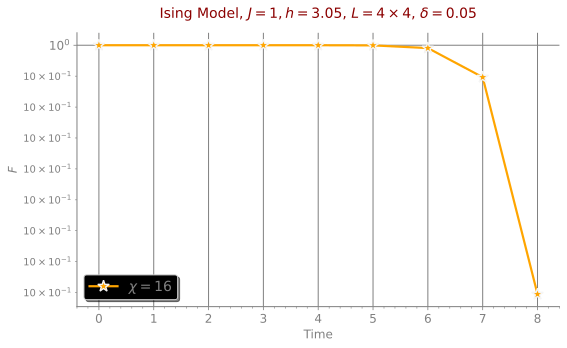

In [12]:
if results["Bp_norm"]:

    plt.figure(figsize=(8, 5))  # compact and clean figure
    

    
    plt.plot(
        results["Bp_norm"], zorder=5, label=r"$\chi=16$",color="orange",
        markersize=12, linewidth=2.2, alpha=1., marker='*', linestyle='-',
        markeredgecolor="whitesmoke", mfc="orange", markeredgewidth=1.4
    )
    
    plt.yscale('log')
    
    # Set axis limits
    # plt.xlim(0, max(t_l))        # adjust x-axis range if needed
    # plt.ylim(0.99, 0.99999)            # adjust y-axis range for log scale
    
    plt.ylabel(r"$F$", fontsize=12)
    plt.xlabel("Time", fontsize=12)
    
    plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.5)
    plt.tick_params(width=0.8, labelsize=12)
    for spine in plt.gca().spines.values():
        spine.set_linewidth(1.)
    
    
    plt.title(rf"Ising Model, $J=1, h=3.05$, $L = {4} \times {4}$, $\delta={0.05}$", fontsize=14, color='darkred', pad=15)  # pad adds space above the plot
    
    plt.grid(color='gray', linestyle='-', linewidth=1., alpha=1.)
    plt.legend(loc='best', frameon=True, shadow=True, fontsize=14)
    plt.tight_layout()
    plt.show()


In [13]:
info_bp |= {"pepo":pepo}
qu.save_to_disk(info_bp, "store_state/info_bp")


['store_state/info_bp']

In [14]:
mpo = quf.mpo_ITF_2d(Lx, Ly, data_type="float64", chi=200, cutoff_val=1.0e-12, field=h, sign="-", print_=False)
inds_k = [ f"k{i}"  for i in range(L)]
inds_b = [ f"b{i}"  for i in range(L)]

Ham_ = np.array(mpo.to_dense(inds_k, inds_b), dtype="complex128")

U_matrix = ar.do("linalg.expm", -1j * Ham_ * t)
U_matrix = to_backend_c(U_matrix)
print("U shape:", U_matrix.shape, t)
print("Unitary?", np.allclose(U_matrix.conj().T @ U_matrix, np.eye(Ham_.shape[0])))

model= -* \sum<ij> Z_iZ_j + -*3.05 X
U shape: torch.Size([4096, 4096]) 0.49999999999999994
Unitary? True


In [15]:
F = algo.gate_fidelity(pepo_m, U_matrix)
print("F=", F, 1 - F)


NameError: name 'pepo_m' is not defined

In [ ]:
pepo_t = quf.pepo_trotter_ITF(edges, Lx=Lx, Ly=Ly, to_backend=to_backend_c, h=h, J=J, delta=0.5)
# pepo_t = quf.pepo_trotter_ITF_fourth(edges, Lx=Lx, Ly=Ly, to_backend=to_backend_c, h=h, J=J, delta=0.5)

pepo_m = pepo_t.to_dense(ind_b, ind_k)


In [ ]:
F = algo.gate_fidelity(pepo_m, U_matrix)
print("F=", F, 1 - F)


In [ ]:
# pepo_t = quf.pepo_trotter_ITF(edges, Lx=Lx, Ly=Ly, to_backend=to_backend_c, h=h, J=J, delta=0.5)
pepo_t = quf.pepo_trotter_ITF_fourth(edges, Lx=Lx, Ly=Ly, to_backend=to_backend_c, h=h, J=J, delta=0.5)

pepo_m = pepo_t.to_dense(ind_b, ind_k)


In [ ]:
F = algo.gate_fidelity(pepo_m, U_matrix)
print("F=", F, 1 - F)
